In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob
import os
import seaborn as sns
import numpy as np 

from parse_cesar1 import load_process_data
from pyprocessta.preprocess.resample import resample_regular
from pyprocessta.preprocess.clean import drop_duplicated_indices
from pyprocessta.preprocess.align import align_two_dfs
from pyprocessta.preprocess.detrend import detrend_stochastic, detrend_linear_deterministc
from pyprocessta.eda.statistics import check_stationarity, check_granger_causality, computer_granger_causality_matrix
from pyprocessta.preprocess.smooth import z_score_filter, exponential_window_smoothing

plt.style.use('science')

## Load data and simple plots

There are some parsing steps that are specific to this dataset wherefore they are not implemented in `pyprocessta`. 

In [3]:
FOLDER = '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data'

In [4]:
all_files = sorted(glob(os.path.join(FOLDER, "*xlsx")))

In [7]:
all_files

['/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day0.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day1.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day2.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day3.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day4.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day5.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day6.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day7.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day8.xlsx',
 '/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day9.xlsx']

In [8]:
all_df_meas = []
all_df_gas = []
times = []

for file in all_files: 
    a, b, t = load_process_data(file)
    
    all_df_meas.append(a)
    all_df_gas.append(b)
    times.append(t)

valve NOT in columns
valve NOT in columns
valve NOT in columns
valve NOT in columns
valve NOT in columns
/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day4.xlsx 'Date'
valve NOT in columns
/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day5.xlsx 'Date'
valve NOT in columns
/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day6.xlsx 'Date'
valve NOT in columns
/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day7.xlsx 'Date'
valve in columns
/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day8.xlsx 'Date'
valve in columns
/Users/kevinmaikjablonka/Dropbox (LSMO)/process_ml_hw_rw/data/RWE_raw_data/day9.xlsx 'Date'


In [9]:
import pickle 

with open('step_times.pkl', 'wb') as handle: 
    pickle.dump(times, handle)

In [10]:
df_gas = pd.concat(all_df_gas)
df_meas = pd.concat(all_df_meas)

In [11]:
GAS_COLUMNS = ['H2O', 'Carbon dioxide CO2', 'Ammonia NH3','2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 'Oxygen']

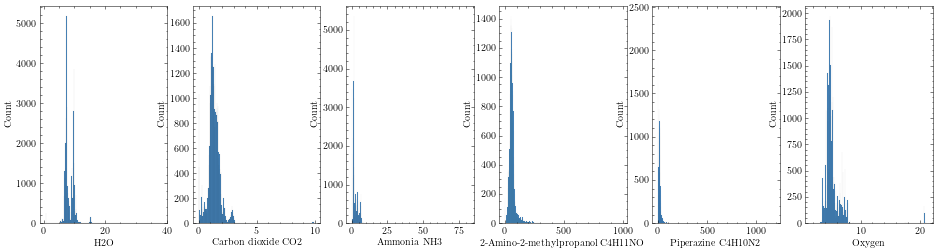

In [12]:
fig, ax = plt.subplots(1,6, figsize=(16,4))
for i, column in enumerate(GAS_COLUMNS): 
    if df_gas[column].dtype == 'float64':
        sns.histplot(df_gas[column], ax= ax[i])
        ax[i].set_xlabel(column)

In [13]:
MEAS_COLUMNS =[ 'PI-2', 'TI-2', 'FI-2', 'PI-3', 'TI-3', 'CO2-3', 'O2-3',
       'TI-32', 'TI-33', 'TI-34', 'TI-35', 'PI-4', 'TI-4', 'FI-4', 'CO2-4',
       'NH3-4', 'FI-11', 'TI-12', 'TI-13', 'FI-20', 'FI-211', 'TI-211', 'TI-8',
       'TI-9', 'TI-5', 'TI-7', 'TI-28', 'PI-28', 'PI-30', 'TI-30', 'FI-30',
       'FI-38', 'PI-38', 'FI-36', 'TI-36', 'Reboiler duty', 'FI-19', 'TI-19',
       'PI-1', 'TI-1',  'FI-35', 'TI-39', 'FI-23', 'TI-22',
       'Level Desorber', 'Level Reboiler', 'TI-24', 'TI-25', 'FI-25', 'FI-16',
       'TI-16', 'FI-151', 'TI-151', 'TI-152', 'TI-212', 'FI-241', 'TI-241',
       'TI-242', 'valve-position-12', 'TI-1213']

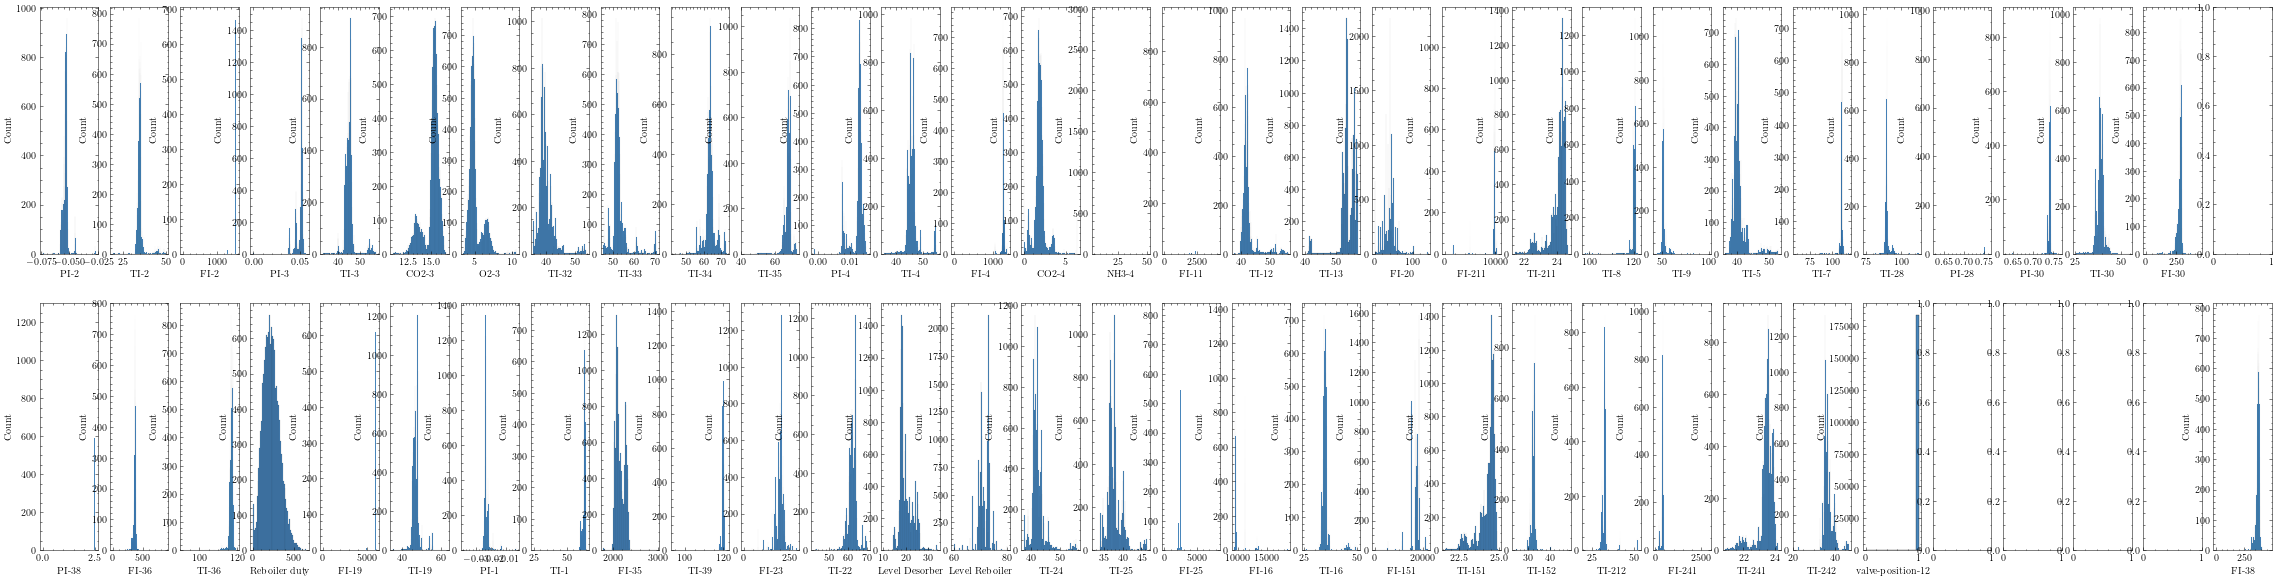

In [14]:
fig, ax = plt.subplots(2,32, figsize=(40,10))
for i, column in enumerate(MEAS_COLUMNS): 
    if df_meas[column].dtype == 'float64':
        if i < 31: 
            row = 0
            col = i
        else: 
            row = 1
            col = i - 32
        sns.histplot(df_meas[column], ax= ax[row][col])
        ax[row][col].set_xlabel(column)

In [15]:
df_meas['valve-position-12'].unique()

array([ 1.,  0., nan])

In [16]:
import datetime 

start = datetime.datetime(2020, 1, 15, 14, 10)

In [17]:
TARGETS = ["2-Amino-2-methylpropanol C4H11NO", "Piperazine C4H10N2", "Carbon dioxide CO2", "Ammonia NH3"]

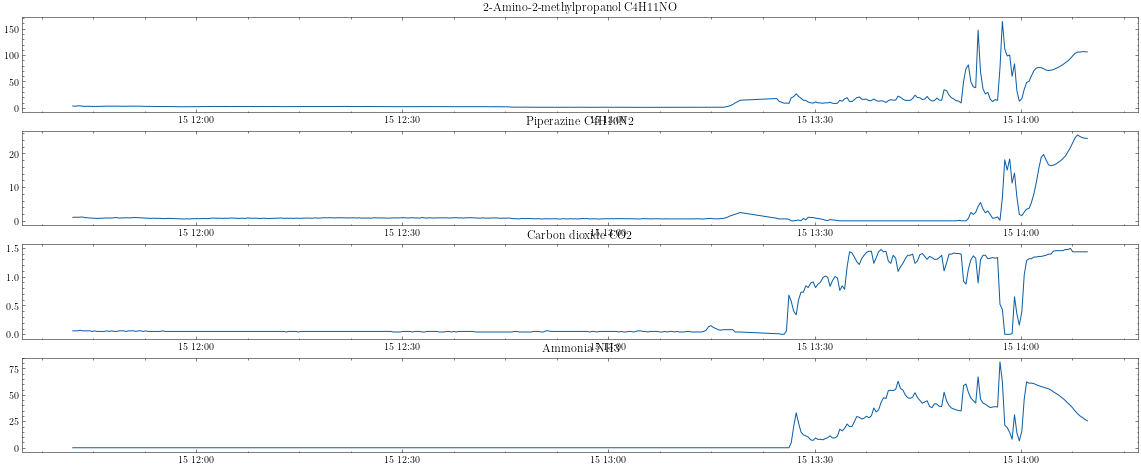

In [20]:
fig, ax = plt.subplots(4,1, figsize=(20,8))

for i, target in enumerate(TARGETS):
    ax[i].set_title(target)
    ax[i].plot(df_gas[df_gas.index < start][target])

## Resample and clean data

For the stationarity analysis and so on we assume that the data is on a regular grid.

In [72]:
pd.set_option('display.max_columns', None)


### Measurement dataframe

In [99]:
df_meas_ss = df_meas[MEAS_COLUMNS].dropna()

In [100]:
df_meas_ss['TI-1213'] = df_meas_ss['TI-1213'].astype(float)

In [101]:
df_meas_ss = drop_duplicated_indices(df_meas_ss) # due to the concatenation there might be duplicated indices

In [102]:
df_meas_regular = resample_regular(df_meas_ss, '1min')

### Gas dataframe

In [119]:
GAS_COLUMNS = ['Carbon dioxide CO2',
 'Ammonia NH3',
 '2-Amino-2-methylpropanol C4H11NO',
 'Piperazine C4H10N2']

In [120]:
df_gas_ss = df_gas[GAS_COLUMNS].dropna()

In [124]:
df_gas_ss = drop_duplicated_indices(df_gas_ss) # due to the concatenation there might be duplicated indices

In [125]:
df_gas_regular = resample_regular(df_gas_ss, '30s')

### Now, we can align them 

In [127]:
aligned_data =  align_two_dfs(df_gas_ss, df_meas_ss)

In [129]:
good_days = [15,16, 17, 20, 21,22,23,24]

good_rows = []
for i in range(len(aligned_data)):
    if aligned_data.index[i].day in good_days:
        good_rows.append(aligned_data.iloc[i])

In [130]:
first_two_sessions = pd.DataFrame(good_rows)

### Resample once more 

We do this to remove some of the spikes (aerosol emissions) and we anyhow should not expect to predict more accurate than this 

In [132]:
TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 
                 "Carbon dioxide CO2", "Ammonia NH3"]

In [133]:
aligned_data = resample_regular(first_two_sessions, '2min')

## Plot time series 

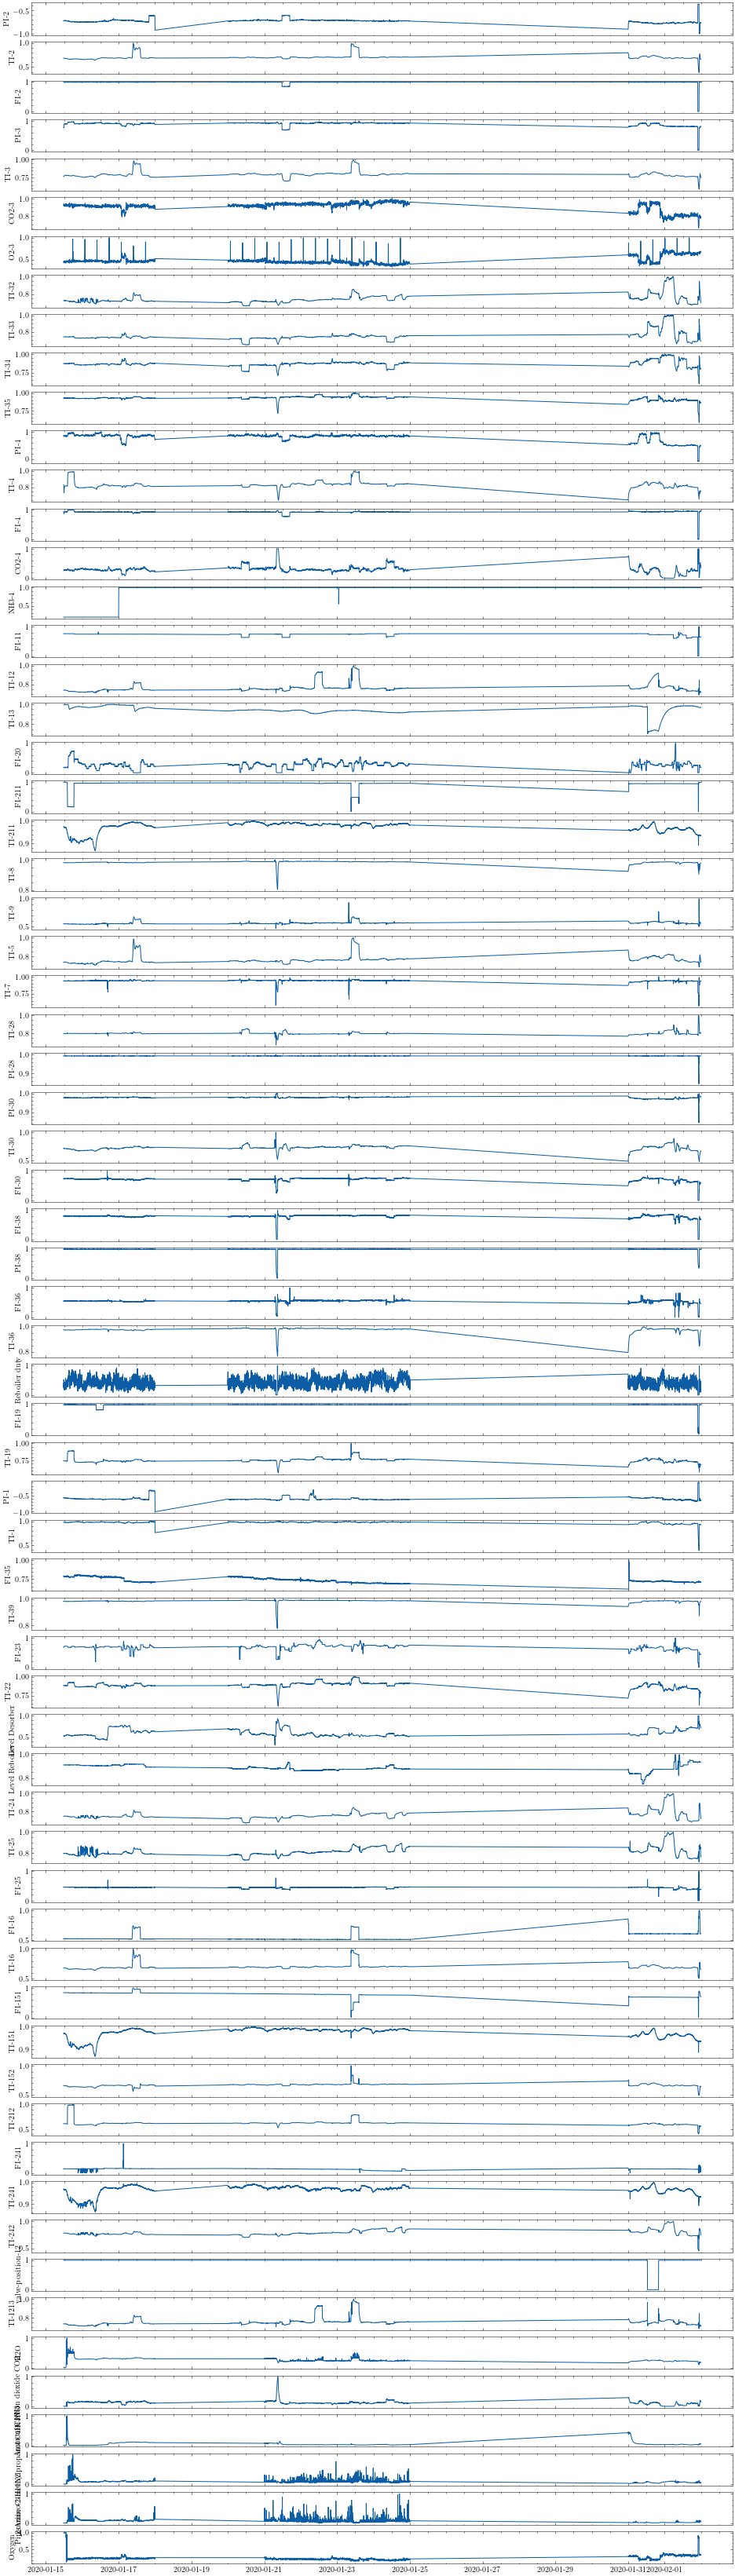

In [139]:
all_columns = MEAS_COLUMNS + GAS_COLUMNS

fig, ax = plt.subplots(len(all_columns), 1, figsize=(16,60), sharex='all')
for i, colunmn in enumerate(all_columns): 
    ax[i].plot(aligned_data[colunmn]/np.abs(aligned_data[colunmn]).max())
    ax[i].set_ylabel(colunmn)
    
fig.savefig('raw_timeseries.pdf', bbox_inches='tight')

## Perform statistical tests for stationarity

In [140]:
stationarity_test_results = []


for column in aligned_data: 
    r = {
        "name": column, 
        'raw': check_stationarity(aligned_data[colunmn])['stationary'], 
        'stochastic_detrend': check_stationarity(detrend_stochastic(aligned_data[colunmn]))['stationary'], 
        'deterministic_detrend': check_stationarity(detrend_linear_deterministc(aligned_data[colunmn]))['stationary']
    }
    
    stationarity_test_results.append(r)

/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/kevinmaikjablonka/opt/miniconda3/envs/pyprocessta/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-valu

In [141]:
results = pd.DataFrame(stationarity_test_results)

In [142]:
results.to_csv('detrending.csv', index=False)

In [143]:
results

,name,raw,stochastic_detrend,deterministic_detrend
0,H2O,False,True,False
1,Carbon dioxide CO2,False,True,False
2,Ammonia NH3,False,True,False
3,2-Amino-2-methylpropanol C4H11NO,False,True,False
4,Piperazine C4H10N2,False,True,False
...,...,...,...,...
61,FI-241,False,True,False
62,TI-241,False,True,False
63,TI-242,False,True,False
64,valve-position-12,False,True,False


It seems that I'll work on the derivative for this reason ...

In [135]:
aligned_data.to_csv('aligned_data.csv', index=False)

## Detrend the data

In [136]:
new_df = []

for column in aligned_data:
    new_df.append(detrend_stochastic(aligned_data[column]))

In [137]:
smoothed_dat = pd.concat(new_df,axis =1)

In [150]:
smoothed_dat.to_csv('detrended.csv', index=False)

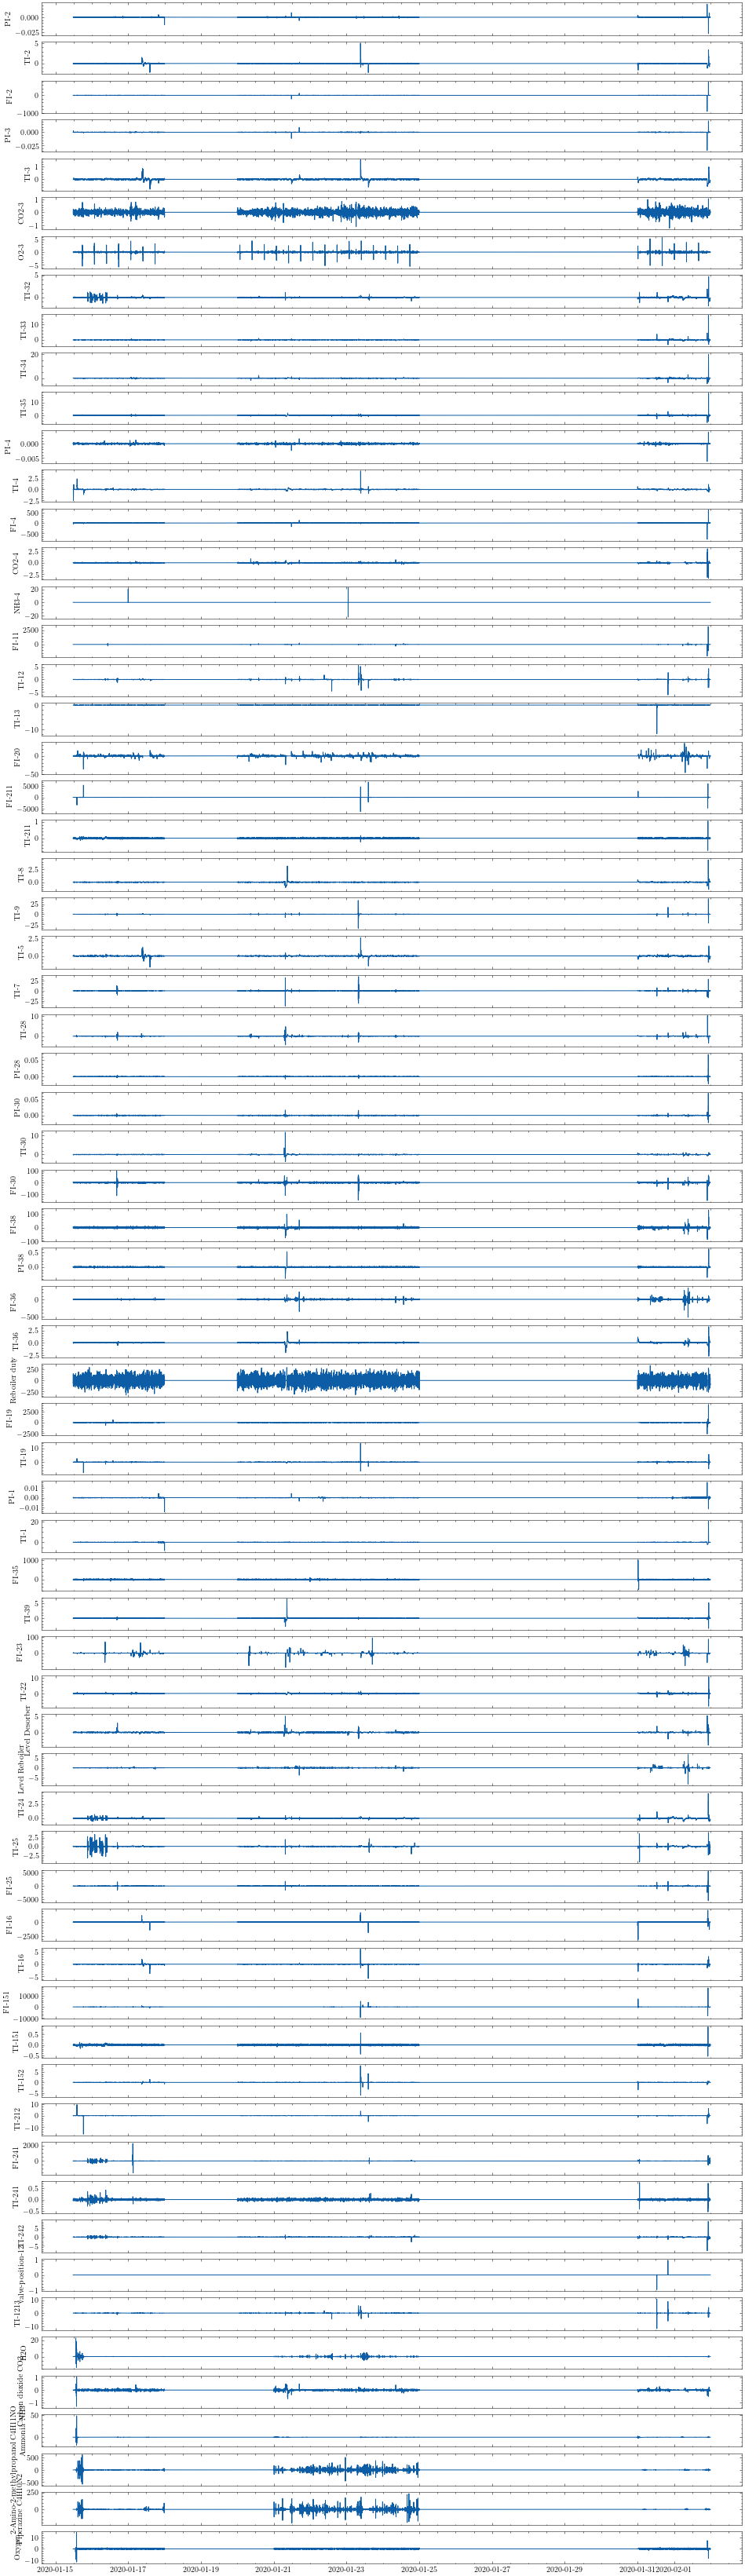

In [151]:
all_columns = MEAS_COLUMNS + GAS_COLUMNS

fig, ax = plt.subplots(len(all_columns), 1, figsize=(16,60), sharex='all')
for i, colunmn in enumerate(all_columns): 
    ax[i].plot(smoothed_dat[colunmn])
    ax[i].set_ylabel(colunmn)
    
fig.savefig('detrend_timeseries.pdf', bbox_inches='tight')

Remove deterministc trend

In [138]:
new_detrended = []

for column in aligned_data:
    if column != 'valve-position-12':
        new_detrended.append(detrend_linear_deterministc(aligned_data[column]))
    else:
        new_detrended.append(aligned_data[column])

In [139]:
detrended_dat = pd.concat(new_detrended,axis =1)

In [140]:
detrended_dat.to_pickle('detrended.pkl')

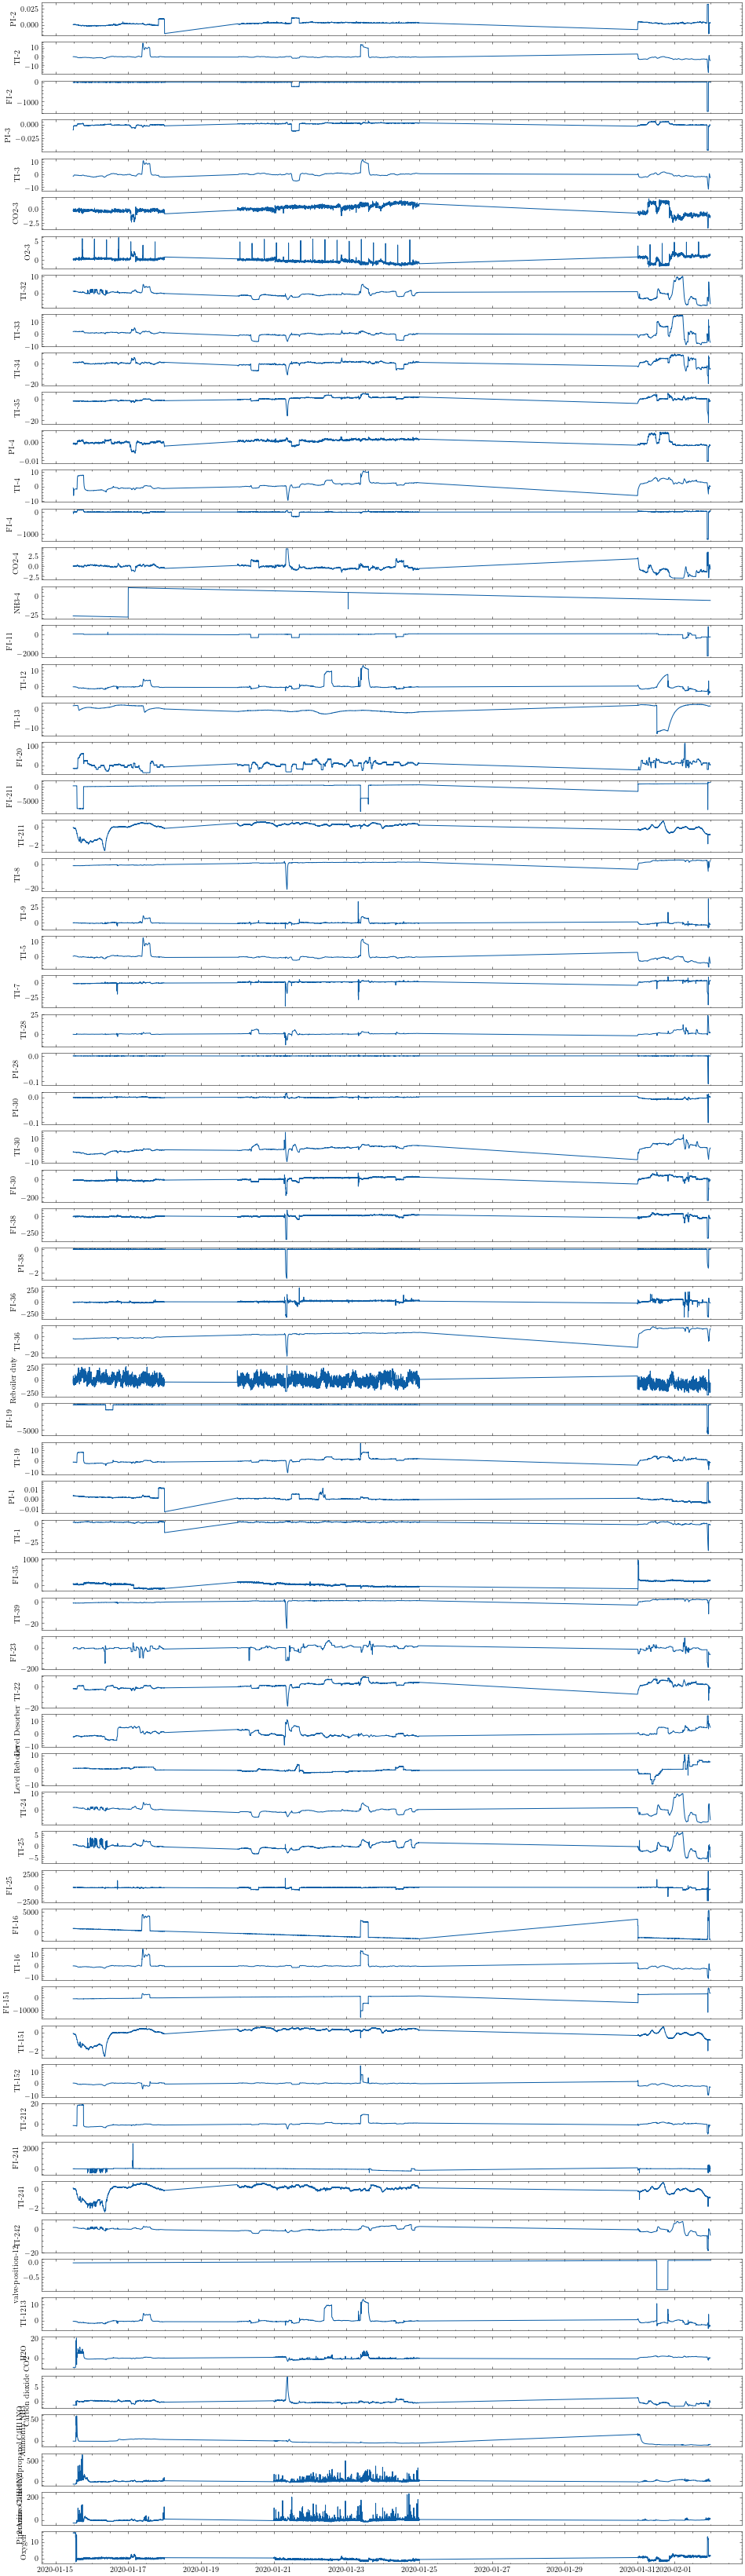

In [155]:
all_columns = MEAS_COLUMNS + GAS_COLUMNS

fig, ax = plt.subplots(len(all_columns), 1, figsize=(16,60), sharex='all')
for i, colunmn in enumerate(all_columns): 
    ax[i].plot(detrended_dat[colunmn])
    ax[i].set_ylabel(colunmn)
    
fig.savefig('detrend_deterministc_timeseries.pdf', bbox_inches='tight')

In [156]:
detrended_dat.to_csv('detrended_deterministic.csv', index=False)

## Smoothen the data

Now, we can apply some exponential window averaging.

In [101]:
smoothened_data = exponential_window_smoothing(detrended_dat, 2)

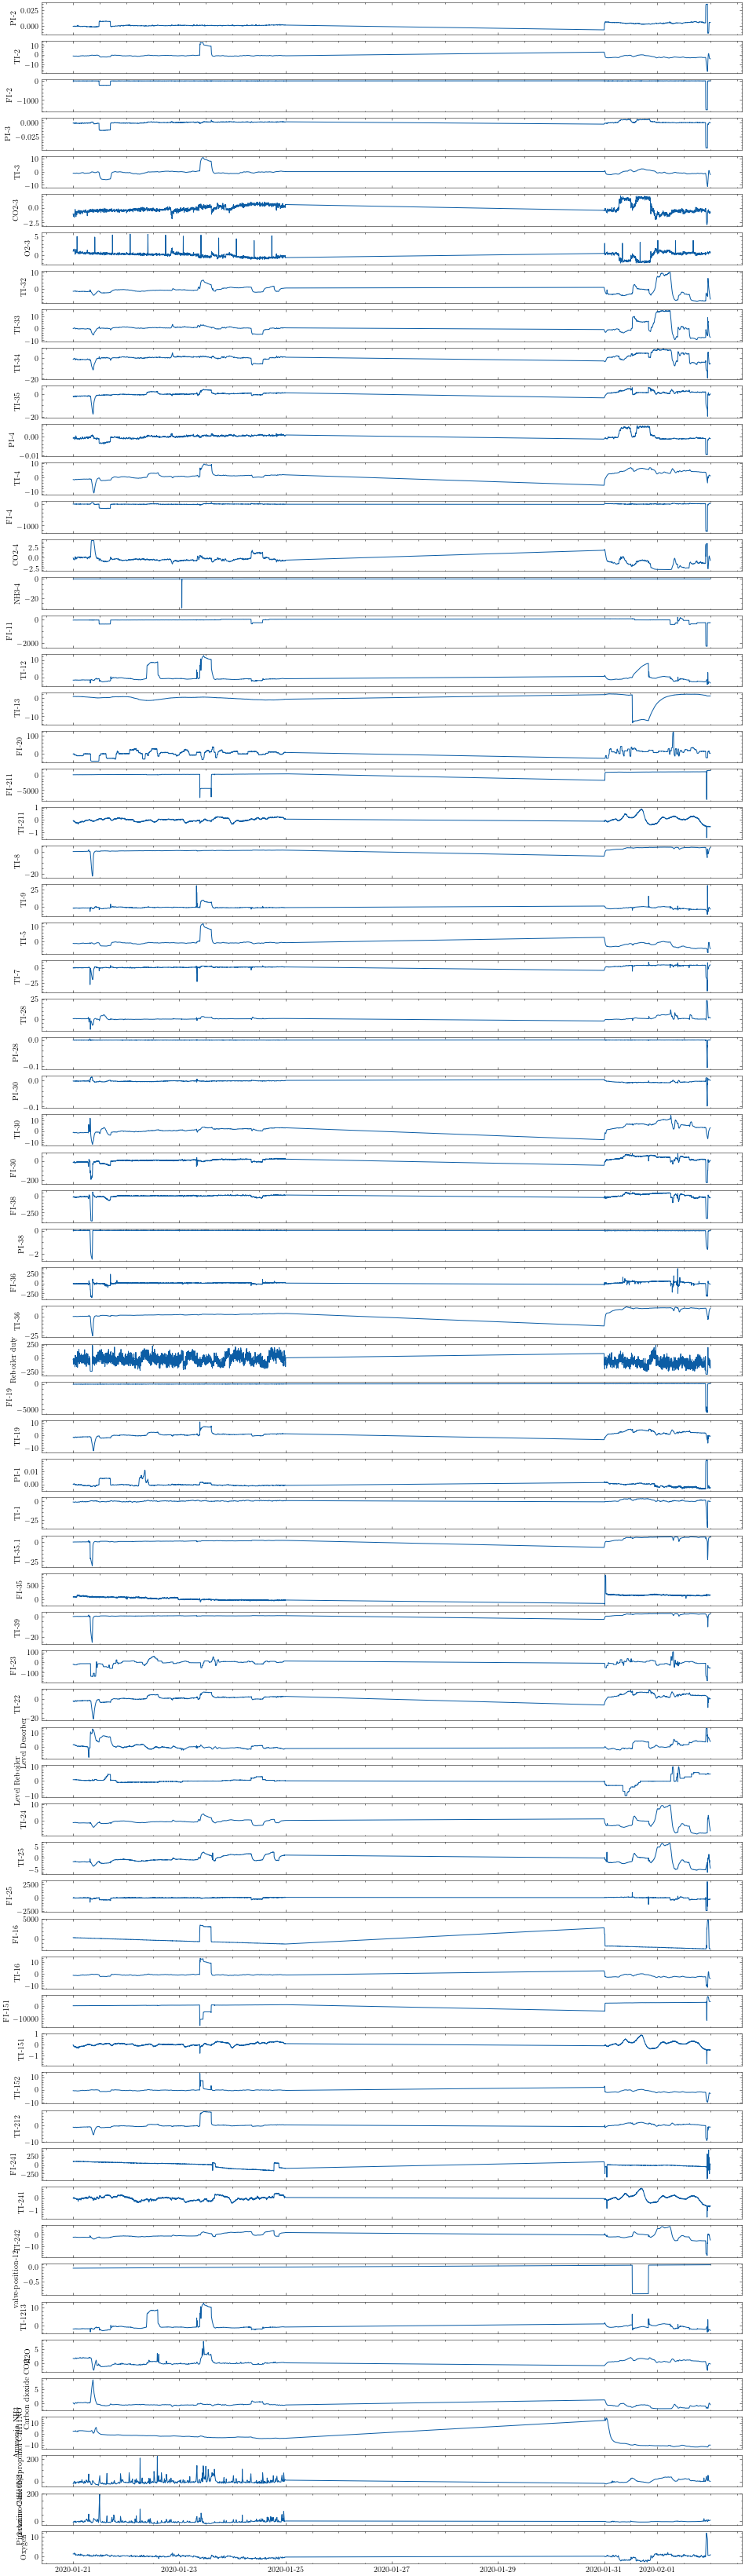

In [102]:
all_columns = MEAS_COLUMNS + GAS_COLUMNS

fig, ax = plt.subplots(len(all_columns), 1, figsize=(16,60), sharex='all')
for i, colunmn in enumerate(all_columns): 
    ax[i].plot(smoothened_data[colunmn])
    ax[i].set_ylabel(colunmn)
    
fig.savefig('smoothened_data.pdf', bbox_inches='tight')

In [103]:
smoothened_data.to_csv('smoothned.csv', index=False)

## Despike the data

In [104]:
despiked = z_score_filter(smoothened_data, 3)

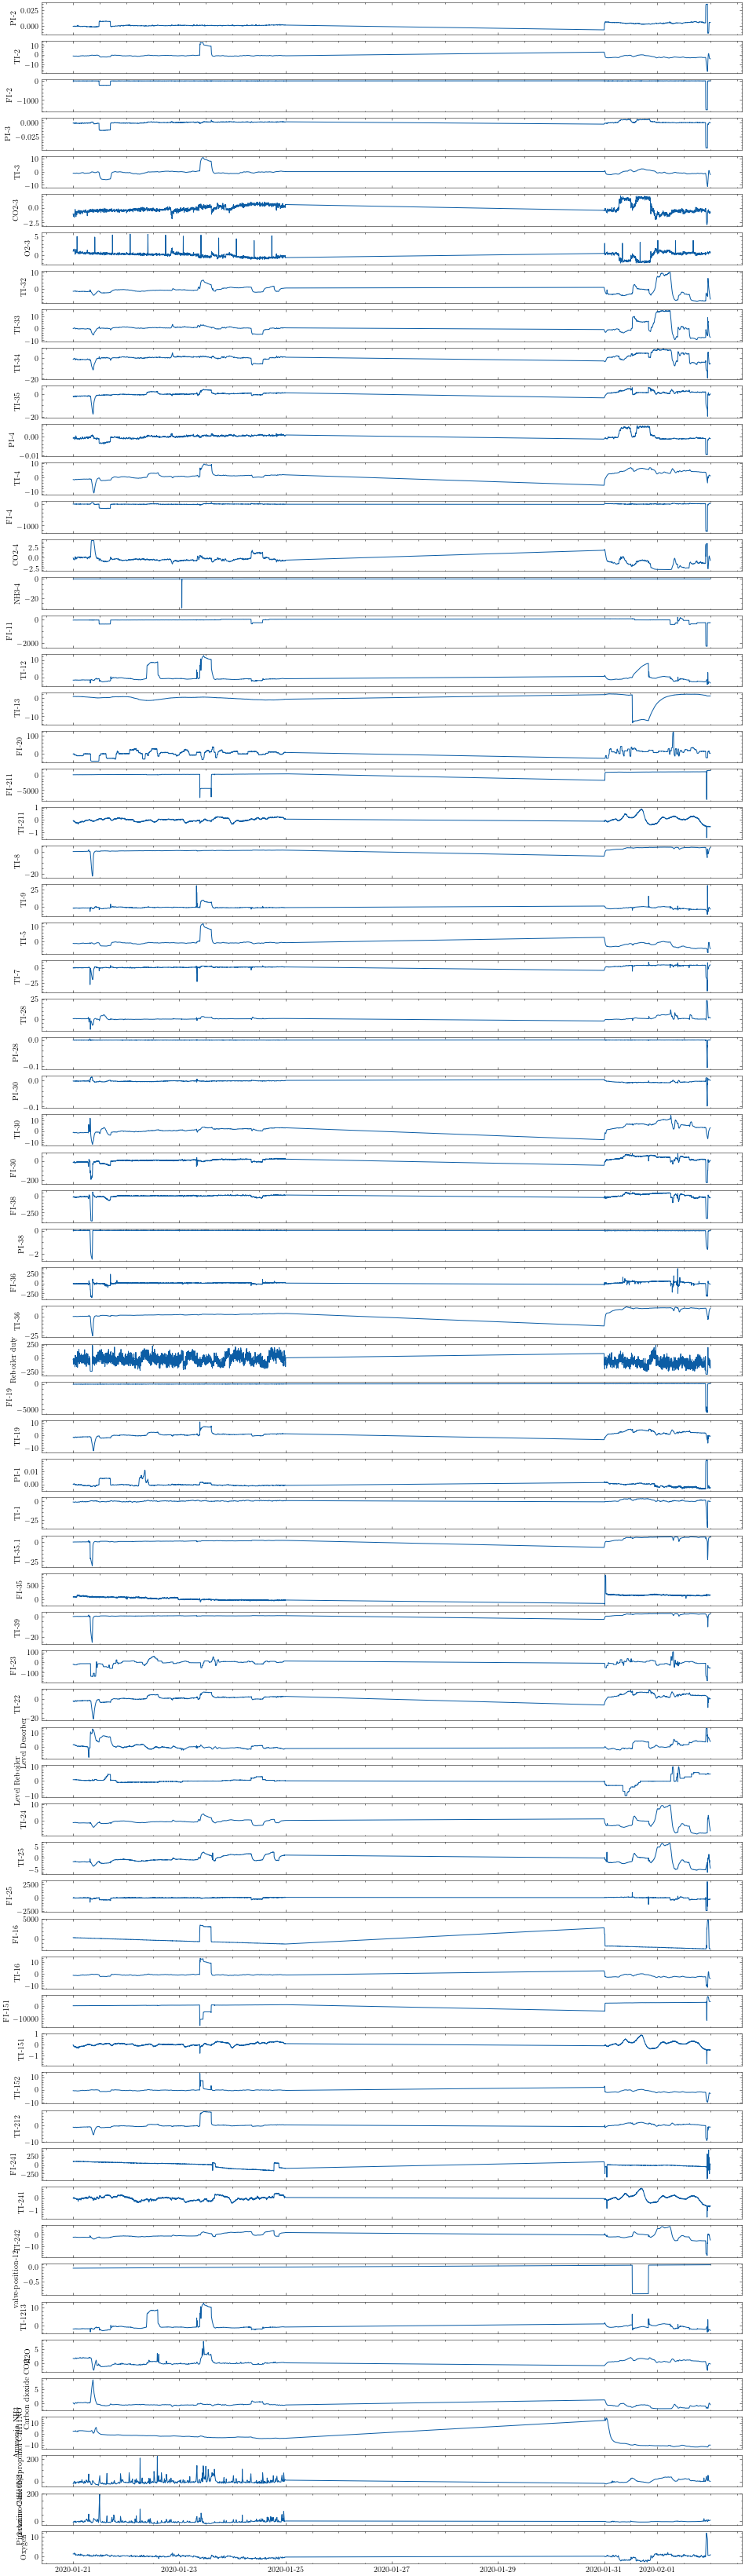

In [105]:
all_columns = MEAS_COLUMNS + GAS_COLUMNS

fig, ax = plt.subplots(len(all_columns), 1, figsize=(16,60), sharex='all')
for i, colunmn in enumerate(all_columns): 
    ax[i].plot(despiked[colunmn])
    ax[i].set_ylabel(colunmn)
    
fig.savefig('despiked_data.pdf', bbox_inches='tight')

In [106]:
despiked.to_pickle('despiked.pkl')

## Granger causality analysis

In [42]:
granger_matrix = computer_granger_causality_matrix(detrended_dat, MEAS_COLUMNS, GAS_COLUMNS)

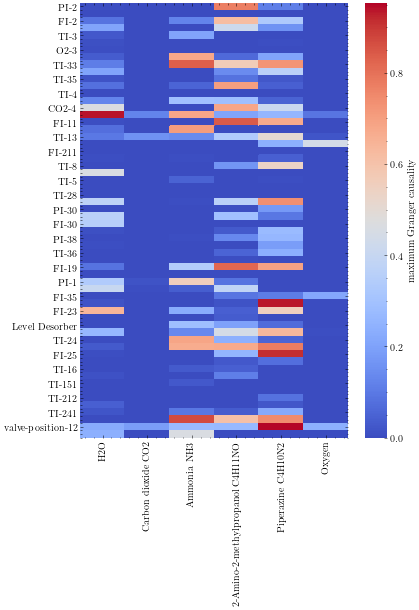

In [46]:
fig, ax = plt.subplots(1,1, figsize=(6,8))
sns.heatmap(granger_matrix, ax=ax, cmap='coolwarm',cbar_kws={'label': 'maximum Granger causality'})

fig.savefig('granger_causality.pdf', bbox_inches='tight')